# Single Experiment

In this notebook we run a single experiment and display the estimates of the dynamic effects based on our dynamic DML algorithm. We also display some performance of alternative benchmark approaches.

## 1. Data Generation from a Markovian Treatment Model

We consider the following DGP:

\begin{align}
    X_t =& (\pi'X_{t-1} + 1) \cdot A\, T_{t-1} + B X_{t-1} + \epsilon_t\\
    T_t =& \gamma\, T_{t-1} + (1-\gamma) \cdot D X_t + \zeta_t\\
    Y_t =& (\sigma' X_{t} + 1) \cdot e\, T_{t} + f' X_t + \eta_t
\end{align}

with $X_0, T_0 = 0$ and $\epsilon_t, \zeta_t, \eta_t$ normal $N(0, \sigma^2)$ r.v.'s. Moreover, $X_t \in R^{n_x}$, $B[:, 0:s_x] \neq 0$ and $B[:, s_x:-1] = 0$, $\gamma\in [0, 1]$, $D[:, 0:s_x] \neq 0$, $D[:, s_x:-1]=0$, $f[0:s_x]\neq 0$, $f[s_x:-1]=0$. We draw a single time series of samples of length $n\_samples$.

In [1]:
%load_ext autoreload
%autoreload 2

In [148]:
import numpy as np
from dynamic_panel_dgp import DynamicPanelDGP, LongRangeDynamicPanelDGP, EndogenousDynamicPanelDGP
from dynamic_panel_dgp import PastTreatmentHeteroDynamicPanelDGP
n_units = 500
n_periods = 3
n_treatments = 1
n_x = 450
s_x = 1 # the first s_x features are relevant and endogenous
s_t = 1
sigma_x = .8
sigma_t = .8
sigma_y = .1
gamma = 0
autoreg = .25
state_effect = .25
conf_str = 5
true_hetero_inds = np.arange(n_x-n_treatments, n_x) # subset of features that are exogenous and create heterogeneity
hetero_strength = .5 # strength of heterogeneity wrt the exogenous variables (assumed to be the last s_x features)
hetero_inds = np.arange(n_x-n_treatments, n_x) # subset of features wrt we estimate heterogeneity
#hetero_inds = np.empty(shape=(0,)).astype(int) 

#dgp_class = LongRangeDynamicPanelDGP
dgp_class = DynamicPanelDGP
#dgp_class = EndogenousDynamicPanelDGP
#dgp_class = PastTreatmentHeteroDynamicPanelDGP
dgp = dgp_class(n_periods, n_treatments, n_x).create_instance(s_x, sigma_x, sigma_y,
                                                              conf_str, hetero_strength, true_hetero_inds,
                                                              autoreg, state_effect,
                                                              random_seed=368)

In [149]:
Y, T, X, groups = dgp.observational_data(n_units, gamma, s_t, sigma_t, random_seed=1245)
panelX = X.reshape(-1, n_periods, n_x)
panelT = T.reshape(-1, n_periods, n_treatments)
panelY = Y.reshape(-1, n_periods)

In [150]:
true_effect_inds = []
for t in range(n_treatments):
    true_effect_inds += [t * (1 + n_x)] + (list(t * (1 + n_x) + 1 + hetero_inds) if len(hetero_inds)>0 else [])
true_effect_params = dgp.true_hetero_effect[:, true_effect_inds].flatten()

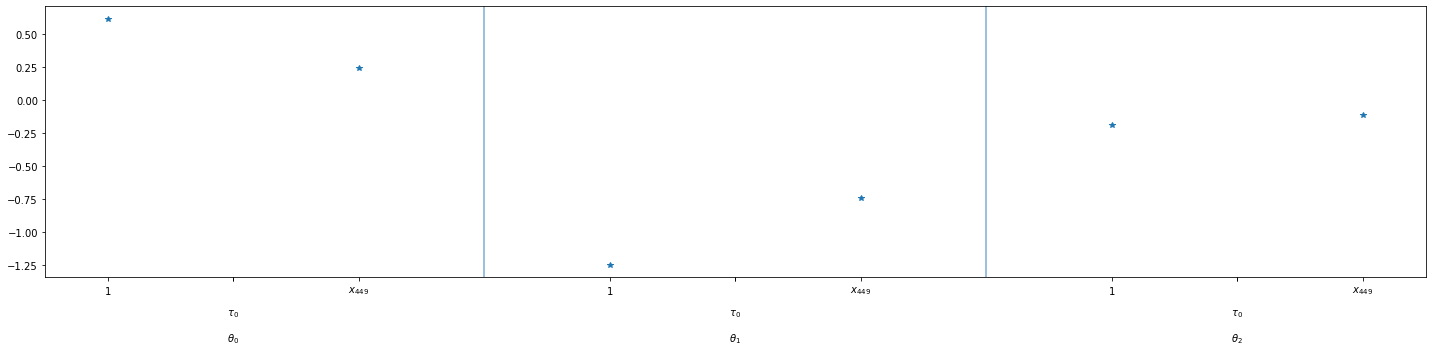

In [151]:
import matplotlib.pyplot as plt 
from coverage_panel_hetero import add_vlines
plt.figure(figsize=(20, 5))
plt.errorbar(np.arange(n_periods * (len(hetero_inds) + 1) * n_treatments),
             true_effect_params.flatten(), fmt='*')
add_vlines(n_periods, n_treatments, hetero_inds)
plt.show()

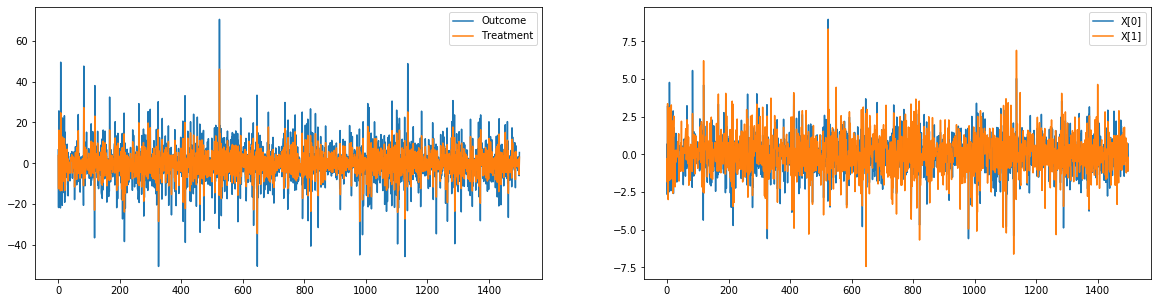

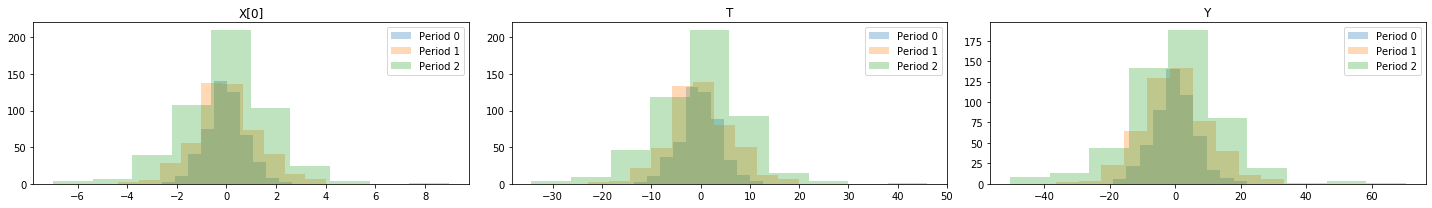

In [152]:
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 5))
plt.subplot(1, 2, 1)
plt.plot(Y, label="Outcome")
plt.plot(T, label="Treatment")
plt.legend()
plt.subplot(1, 2, 2)
for it in range(2):
    plt.plot(X[:, it], label="X[{}]".format(it))
plt.legend()
plt.show()

plt.figure(figsize=(20, 3))
plt.subplot(1, 3, 1)
for t in range(n_periods):
    plt.hist(panelX[:, t, 0], alpha=.3, label="Period {}".format(t))
plt.title("X[0]")
plt.legend()

plt.subplot(1, 3, 2)
for t in range(n_periods):
    plt.hist(panelT[:, t, 0], alpha=.3, label="Period {}".format(t))
plt.title("T")
plt.legend()

plt.subplot(1, 3, 3)
for t in range(n_periods):
    plt.hist(panelY[:, t], alpha=.3, label="Period {}".format(t))
plt.title("Y")
plt.legend()
plt.tight_layout()
plt.show()

## 2. Dynamic DML

In [153]:
from sklearn.linear_model import LinearRegression, LassoCV, Lasso, MultiTaskLasso, MultiTaskLassoCV
from sklearn.model_selection import GroupKFold, KFold
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.multioutput import MultiOutputRegressor
import lightgbm as lgb
import warnings
warnings.simplefilter('ignore')

np.random.seed(123)
from econml.sklearn_extensions.linear_model import SelectiveRegularization

lasso_model = lambda : LassoCV(cv=3, n_alphas=6, max_iter=200)
gb_model = lambda : GradientBoostingRegressor(n_estimators=100, max_depth=3,
                                                 min_samples_leaf=50, min_impurity_decrease=.1)
lgbm_model = lambda : lgb.LGBMRegressor()
mlasso_model = lambda : MultiTaskLassoCV(cv=3, n_alphas=6, max_iter=200)
mgb_model = lambda : MultiOutputRegressor(GradientBoostingRegressor(n_estimators=100, max_depth=3,
                                                                       min_samples_leaf=50, min_impurity_decrease=.1))
mlgbm_model = lambda : MultiOutputRegressor(lgb.LGBMRegressor())

alpha_regs = [1e-4, 1e-3, 5e-2, 1e-1, .5, 1]
slasso_model = lambda : SelectiveRegularization([0],
                                                LassoCV(cv=KFold(n_splits=3, shuffle=True),
                                                        alphas=alpha_regs, max_iter=200, fit_intercept=False),
                                                fit_intercept=False)

In [154]:
from hetero_panel_dynamic_dml import HeteroDynamicPanelDML

est = HeteroDynamicPanelDML(model_t=mlasso_model(),
                            model_y=lasso_model(),
                            model_final=slasso_model(),
                            n_cfit_splits=3).fit(Y, T, X, groups, hetero_inds=hetero_inds)

### 2.1 Parameter Recovery and Confidence Intervals

In [155]:
param_hat = est.param
conf_ints = est.param_interval(alpha=.01)
for kappa in range(n_periods):
    for t in range(n_treatments * (len(hetero_inds) + 1)):
        param_ind = kappa * (len(hetero_inds) + 1) * n_treatments + t
        print("Effect Lag={}, TX={}: {:.3f} ({:.3f}, {:.3f}), (Truth={:.3f})".format(kappa, t,
                                                                                    param_hat[param_ind],
                                                                                    *conf_ints[param_ind],
                                                                                    true_effect_params[param_ind]))

Effect Lag=0, TX=0: 0.841 (0.613, 1.068), (Truth=0.619)
Effect Lag=0, TX=1: 0.706 (0.278, 1.135), (Truth=0.243)
Effect Lag=1, TX=0: -1.351 (-2.221, -0.482), (Truth=-1.250)
Effect Lag=1, TX=1: -0.000 (-1.165, 1.165), (Truth=-0.744)
Effect Lag=2, TX=0: -1.001 (-2.640, 0.639), (Truth=-0.188)
Effect Lag=2, TX=1: -1.023 (-2.034, -0.012), (Truth=-0.112)


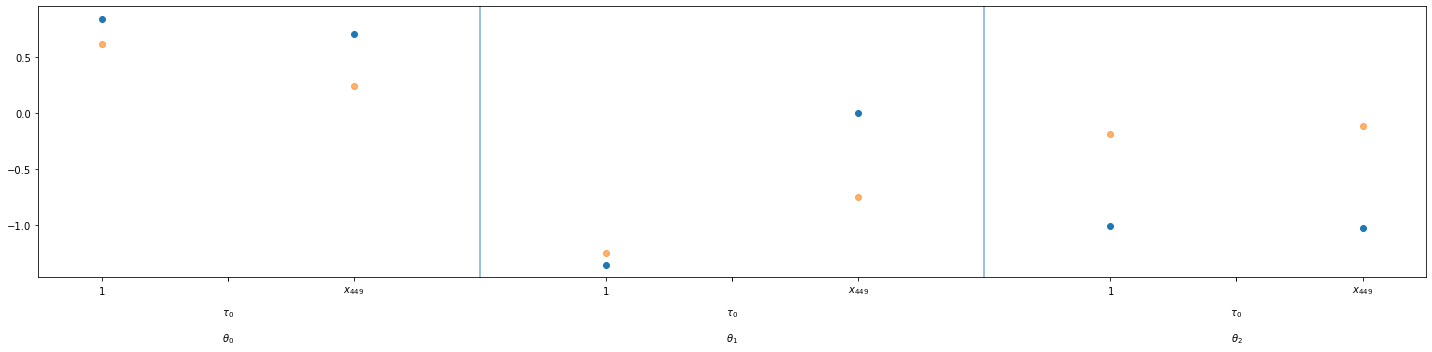

In [156]:
plt.figure(figsize=(20, 5))
plt.errorbar(np.arange(n_periods * (len(hetero_inds) + 1) * n_treatments),
             param_hat, fmt='o')
plt.errorbar(np.arange(n_periods * (len(hetero_inds) + 1) * n_treatments),
             true_effect_params.flatten(), fmt='o', alpha=.6)
add_vlines(n_periods, n_treatments, hetero_inds)
plt.show()

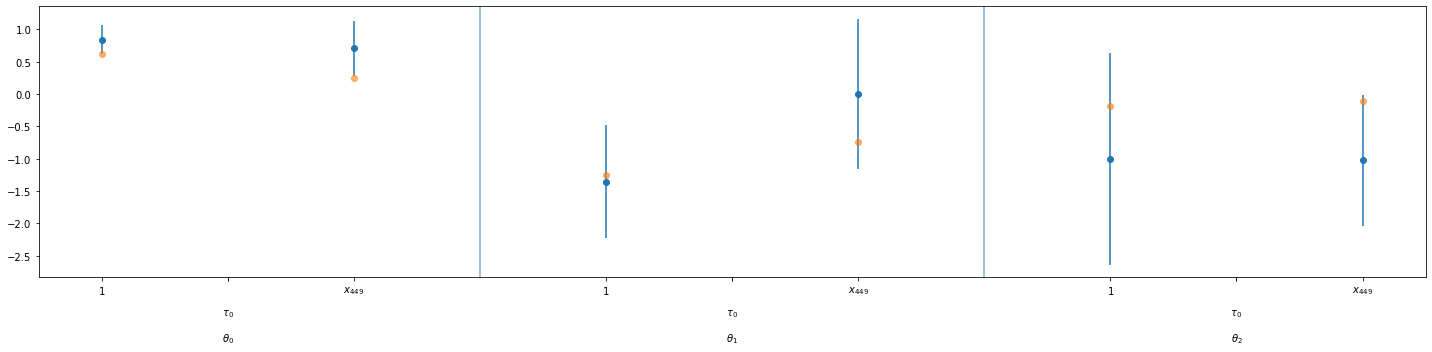

In [157]:
plt.figure(figsize=(20, 5))
plt.errorbar(np.arange(n_periods * (len(hetero_inds) + 1) * n_treatments),
             param_hat, yerr=(conf_ints[:, 1] - param_hat,
                              param_hat - conf_ints[:, 0]), fmt='o')
plt.errorbar(np.arange(n_periods * (len(hetero_inds) + 1) * n_treatments),
             true_effect_params.flatten(), fmt='o', alpha=.6)
add_vlines(n_periods, n_treatments, hetero_inds)
plt.show()

### 2.2 Benchmark Method Comparison

In [158]:
from econml.utilities import cross_product
from statsmodels.tools.tools import add_constant

panelTX = np.zeros((n_units, n_periods, (1 + len(hetero_inds)) * n_treatments))
for t in range(n_periods):
    panelTX[:, t, :] = cross_product(add_constant(panelX[:, t, hetero_inds], has_constant='add'),
                            panelT[:, t, :])

#### 2.2.1 Regressing Y on {T[t]*X[t, hetero_inds]}

In [159]:
est_lr = LinearRegression().fit(panelTX[:, ::-1, :].reshape((n_units, -1)), panelY[:, -1]).coef_

#### 2.2.2 Controlling for Subsets of the States

In [160]:
est_lr_x0 = lasso_model().fit(np.hstack([panelTX[:, ::-1, :].reshape(n_units, -1),
                                  panelX[:, 0, :]]), panelY[:, -1]).coef_[:-n_x]
est_lr_xfinal = lasso_model().fit(np.hstack([panelTX[:, ::-1, :].reshape(n_units, -1),
                                  panelX[:, -1, :]]), panelY[:, -1]).coef_[:-n_x]

#### 2.2.3 Controlling for Subsets of States with Static DML

In [161]:
from econml.dml import LinearDMLCateEstimator
dml_model = lambda : LinearDMLCateEstimator(model_y=lasso_model(), model_t=mlasso_model(),
                                      n_splits=3, linear_first_stages=False)
est_dml_x0 = dml_model().fit(panelY[:, -1], T=panelTX[:, ::-1, :].reshape(n_units, -1),
                      X=None, W=panelX[:, 0, :]).intercept_
est_dml_xfinal = dml_model().fit(panelY[:, -1], T=panelTX[:, ::-1, :].reshape(n_units, -1),
                      X=None, W=panelX[:, -1, :]).intercept_

#### 2.2.4 Direct version of Dynamic DML

In [162]:
Y_cal = panelY[:, -1].copy()
direct_theta = np.zeros((n_periods, (1 + len(hetero_inds) * n_treatments)))
for t in np.arange(n_periods):
    direct_theta[t, :] = lasso_model().fit(np.hstack([panelTX[:, n_periods - 1 - t, :],
                                                      panelX[:, n_periods - 1 - t, :]]), Y_cal).coef_[:-n_x]
    Y_cal -= np.dot(panelTX[:, n_periods - 1 - t, :], direct_theta[t, :])
est_direct = direct_theta.flatten()

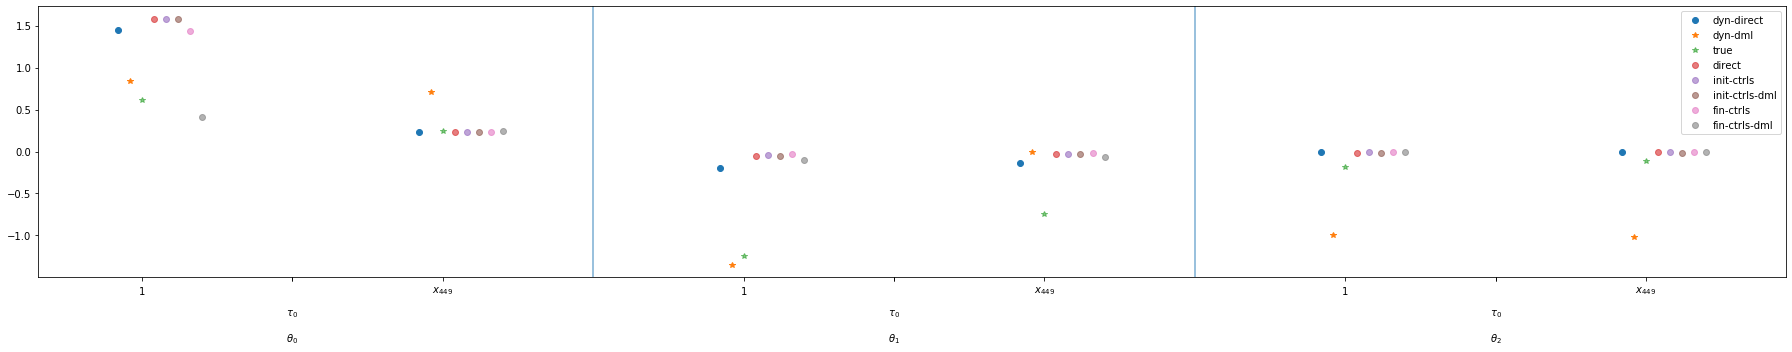

In [163]:
plt.figure(figsize=(25, 5))
plt.errorbar(np.arange(n_periods * (len(hetero_inds) + 1) * n_treatments) - .08,
             est_direct, fmt='o', label='dyn-direct')
plt.errorbar(np.arange(n_periods * (len(hetero_inds) + 1) * n_treatments) - .04,
             param_hat, fmt='*', label='dyn-dml')
plt.errorbar(np.arange(n_periods * (len(hetero_inds) + 1) * n_treatments),
             true_effect_params.flatten(), fmt='*', alpha=.6, label='true')
plt.errorbar(np.arange(n_periods * (len(hetero_inds) + 1) * n_treatments) + .04,
             est_lr.flatten(), fmt='o', alpha=.6, label='direct')
plt.errorbar(np.arange(n_periods * (len(hetero_inds) + 1) * n_treatments) + .08,
             est_lr_x0.flatten(), fmt='o', alpha=.6, label='init-ctrls')
plt.errorbar(np.arange(n_periods * (len(hetero_inds) + 1) * n_treatments) + .12,
             est_dml_x0.flatten(), fmt='o', alpha=.6, label='init-ctrls-dml')
plt.errorbar(np.arange(n_periods * (len(hetero_inds) + 1) * n_treatments) + .16,
             est_lr_xfinal.flatten(), fmt='o', alpha=.6, label='fin-ctrls')
plt.errorbar(np.arange(n_periods * (len(hetero_inds) + 1) * n_treatments) + .20,
             est_dml_xfinal.flatten(), fmt='o', alpha=.6, label='fin-ctrls-dml')
add_vlines(n_periods, n_treatments, hetero_inds)
plt.legend()
plt.tight_layout()
plt.show()

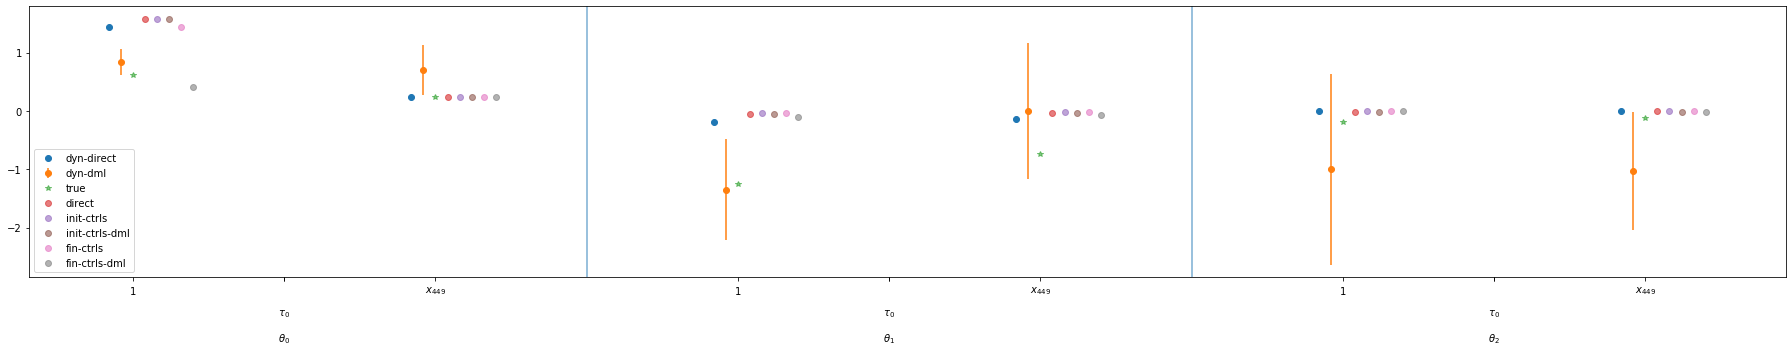

In [164]:
plt.figure(figsize=(25, 5))
plt.errorbar(np.arange(n_periods * (len(hetero_inds) + 1) * n_treatments) - .08,
             est_direct, fmt='o', label='dyn-direct')
plt.errorbar(np.arange(n_periods * (len(hetero_inds) + 1) * n_treatments) - .04,
             param_hat, yerr=(conf_ints[:, 1] - param_hat,
                              param_hat - conf_ints[:, 0]), fmt='o', label='dyn-dml')
plt.errorbar(np.arange(n_periods * (len(hetero_inds) + 1) * n_treatments),
             true_effect_params.flatten(), fmt='*', alpha=.6, label='true')
plt.errorbar(np.arange(n_periods * (len(hetero_inds) + 1) * n_treatments) + .04,
             est_lr.flatten(), fmt='o', alpha=.6, label='direct')
plt.errorbar(np.arange(n_periods * (len(hetero_inds) + 1) * n_treatments) + .08,
             est_lr_x0.flatten(), fmt='o', alpha=.6, label='init-ctrls')
plt.errorbar(np.arange(n_periods * (len(hetero_inds) + 1) * n_treatments) + .12,
             est_dml_x0.flatten(), fmt='o', alpha=.6, label='init-ctrls-dml')
plt.errorbar(np.arange(n_periods * (len(hetero_inds) + 1) * n_treatments) + .16,
             est_lr_xfinal.flatten(), fmt='o', alpha=.6, label='fin-ctrls')
plt.errorbar(np.arange(n_periods * (len(hetero_inds) + 1) * n_treatments) + .20,
             est_dml_xfinal.flatten(), fmt='o', alpha=.6, label='fin-ctrls-dml')
add_vlines(n_periods, n_treatments, hetero_inds)
plt.legend()
plt.tight_layout()
plt.show()

## 3. Policy Effect

In [165]:
tau = np.random.binomial(1, .8, size=(n_periods, n_treatments))
true_policy_effect = dgp.static_policy_effect(tau, mc_samples=1000)
policy_effect_hat, policy_ints, policy_std = est.policy_effect(tau, X[:, hetero_inds], groups)
print("Policy effect for treatment seq: \n {}\n {:.3f} ({:.3f}, {:.3f}), (truth={:.3f})".format(tau,
                                                                                                policy_effect_hat,
                                                                                                *policy_ints,
                                                                                                true_policy_effect))

Policy effect for treatment seq: 
 [[1]
 [1]
 [1]]
 -1.529 (-3.291, 0.234), (truth=-0.830)


#### 3.1 Benchmark Comparison

In [166]:
def static_policy_effect(tau, hetero_params):
    return np.sum([tau[t].reshape(1, -1) @\
                   hetero_params.reshape(n_periods, n_treatments, 1 + len(hetero_inds))[n_periods - 1 - t] @\
                   np.mean(add_constant(panelX[:, t, hetero_inds], has_constant='add'), axis=0)
                   for t in range(n_periods)])

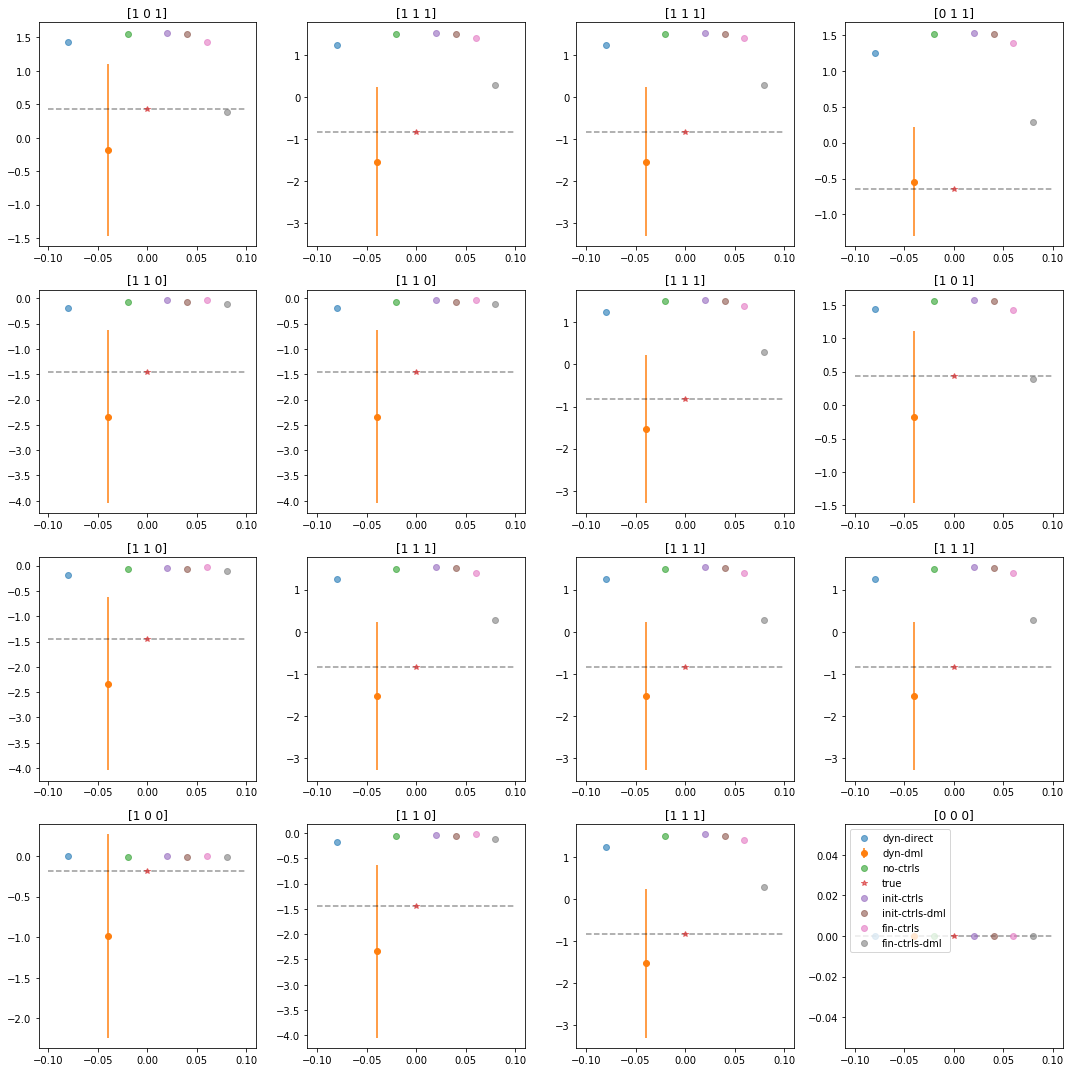

In [167]:
test_policies = np.random.binomial(1, .8, size=(16, n_periods, n_treatments))
test_policies[15, :] = 0

plt.figure(figsize=(15, 15))
for t, tau in enumerate(test_policies):
    true_policy_effect = dgp.static_policy_effect(tau, mc_samples=1000)
    policy_effect_hat, policy_ints, _ = est.policy_effect(tau, X[:, hetero_inds], groups)
    plt.subplot(4, 4, t + 1)
    plt.errorbar([-.08], [static_policy_effect(tau, est_direct)], fmt='o', alpha=.6, label='dyn-direct')
    plt.errorbar([-.04], [policy_effect_hat], yerr=([policy_ints[1] - policy_effect_hat],
                                                  [policy_effect_hat - policy_ints[0]]), fmt='o', label='dyn-dml')
    plt.errorbar([-.02], [static_policy_effect(tau, est_lr)], fmt='o', alpha=.6, label='no-ctrls')
    plt.errorbar([0], [true_policy_effect], fmt='*', alpha=.6, label='true')
    plt.hlines([true_policy_effect], - .1, .10, linestyles='--', alpha=.4)
    plt.errorbar([.02], [static_policy_effect(tau, est_lr_x0)], fmt='o', alpha=.6, label='init-ctrls')
    plt.errorbar([.04], [static_policy_effect(tau, est_dml_x0)], fmt='o', alpha=.6, label='init-ctrls-dml')
    plt.errorbar([.06], [static_policy_effect(tau, est_lr_xfinal)], fmt='o', alpha=.6, label='fin-ctrls')
    plt.errorbar([.08], [static_policy_effect(tau, est_dml_xfinal)], fmt='o', alpha=.6, label='fin-ctrls-dml')
    plt.title("{}".format(tau.flatten()))
plt.legend()
plt.tight_layout()
plt.show()

### 3.2 Adaptive Policy

In [168]:
# Optimal Contextual Binary Treatment Policy
def adaptive_policy(t, x, period):
    return 1*(dgp.hetero_effect_fn(n_periods - 1 - period, x) > 0)
dgp.adaptive_policy_effect(adaptive_policy)

0.6225670514435359

In [169]:
est.adaptive_policy_effect(X, groups, adaptive_policy)

(0.8070629317620176,
 (0.6213266303331364, 0.9927992331908988),
 0.09476516042842899)

## 4. Estimation Diagnostics

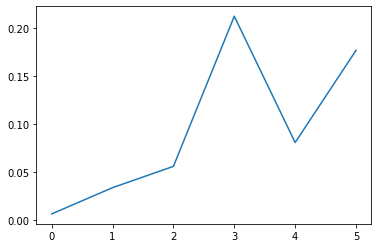

In [131]:
import matplotlib.pyplot as plt
plt.plot(est.param_stderr)
plt.show()

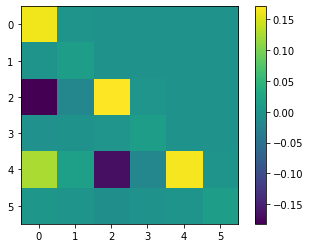

In [132]:
plt.imshow(est._M)
plt.colorbar()
plt.show()

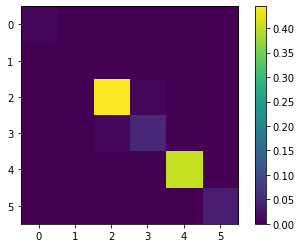

In [133]:
plt.imshow(est._Sigma)
plt.colorbar()
plt.show()